# Machine Learning - Aprendizado Supervisionado


* **Task:** Treinar um modelo de apredizado de máquina supervisionado para prever possíveis churn de clientes do banco Beta Bank, a partir de dados históricos. 
* **Condições:** valor F1 de pelo menos 0,59 para o conjunto de dados de teste. 

## Importando bibliotecas

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,balanced_accuracy_score,\
                            f1_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.utils import shuffle

## Primeira visualização dos dados

In [68]:
data = pd.read_csv('Churn.csv')

In [69]:
# Lendo as primeiras 10 linhas
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [70]:
# Formato do dataset
data.shape

(10000, 14)

In [71]:
# Informações
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Conclusões**

O dataset apresenta 10000 observações e 14 colunas com identificação e informações sobre comportamento dos clientes. A partir disso é possível identificar as características e objetivos para o modelo:

* **Características:**

- <em>RowNumber</em> — índice das strings de dados
- <em>CustomerId</em> — identificador exclusivo do cliente
- <em>Surname</em> — sobrenome
- <em>CreditScore</em> — pontuação de crédito
- <em>Geography</em> — país de residência
- <em>Gender</em> — gênero
- <em>Age</em> — idade
- <em>Tenure</em> — tempo de serviço para o cliente
- <em>Balance</em> — saldo da conta
- <em>NumOfProducts</em> — número de produtos bancários usados pelo cliente
- <em>HasCrCard</em> — cliente possui cartão de crédito (1 - sim; 0 - não)
- <em>IsActiveMember</em> — cliente ativo (1 - sim; 0 - não)
- <em>EstimatedSalary</em> — salário estimado

* **Objetivo:**

- <em>Exited</em> — o cliente saiu (1 - sim; 0 - não)

Além disso, é necessário realizar algumas correções:

* Corrigir o nome das colunas, uma vez que letras maúsculas e minúsculas podem gerar confusão durante processamento dos dados.
    
* Há valores ausentes na coluna 'Tenure' (tempo de serviço para o cliente).

# Análise Exploratória dos dados EDA

## Corrigindo inconsistências e lidando com valores ausentes

In [72]:
# função para renomear colunas e facilitar o entendimento das variáveis
def camel_to_snake(column_name):
    words = re.findall('[A-Z][a-z0-9]*', column_name)
    snake_case = '_'.join([word.lower() for word in words])
    return snake_case

In [73]:
# Passando nome das colunas para letras minúsculas
data.columns = [camel_to_snake(col) for col in data.columns]

In [74]:
# Preenchendo valores ausente com a mediana que não sofre influência de valores extremos
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [75]:
# Resultado
data.isna().mean()

row_number          0.0
customer_id         0.0
surname             0.0
credit_score        0.0
geography           0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
num_of_products     0.0
has_cr_card         0.0
is_active_member    0.0
estimated_salary    0.0
exited              0.0
dtype: float64

In [76]:
# Excluindo a coluna 'surname', pois pode conter diferentes valores nos datasets separados
# Além disso, o sobrenome do cliente não irá influenciar na decisão de deixar o banco
new_data = data.drop('surname', axis=1)

## Análise descritiva

In [77]:
# Verificando a distribuição dos dados
new_data.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [78]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(new_data.select_dtypes(include=numerics).columns.values)

string = ['O']
string_cols= list(new_data.select_dtypes(include=string).columns.values)

In [79]:
numeric_cols = ['credit_score','age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
binary_cols = ['has_cr_card', 'is_active_member', 'exited']
string_cols= ['geography', 'gender']

In [80]:
# Verificando os resultados
print(f'Colunas numéricas: {numeric_cols}')
print(f'Colunas binárias: {binary_cols}')
print(f'Colunas de texto são: {string_cols}')

Colunas numéricas: ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
Colunas binárias: ['has_cr_card', 'is_active_member', 'exited']
Colunas de texto são: ['geography', 'gender']


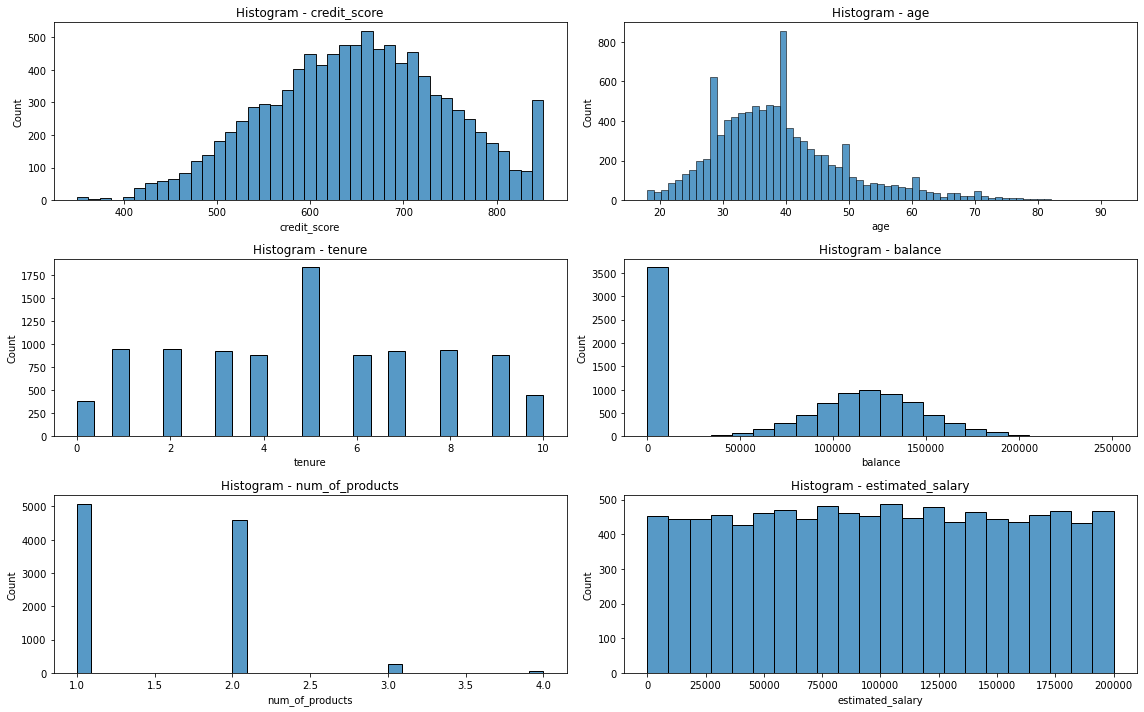

In [81]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))

for i, col in enumerate(numeric_cols):
    ax = axs[i // 2, i % 2]  # Calculate the subplot index based on row and column
    sns.histplot(data=new_data, x=col, ax=ax)
    ax.set_title(f"Histogram - {col}")

plt.tight_layout()
plt.show()

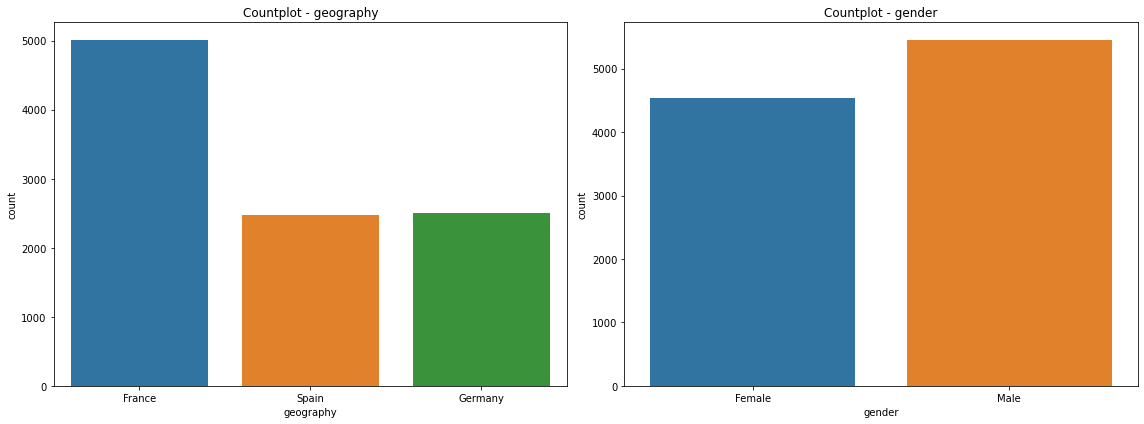

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i, col in enumerate(string_cols):
    ax = axs[i]  
    sns.countplot(data=new_data, x=col, ax=ax)
    ax.set_title(f"Countplot - {col}")

plt.tight_layout()
plt.show()

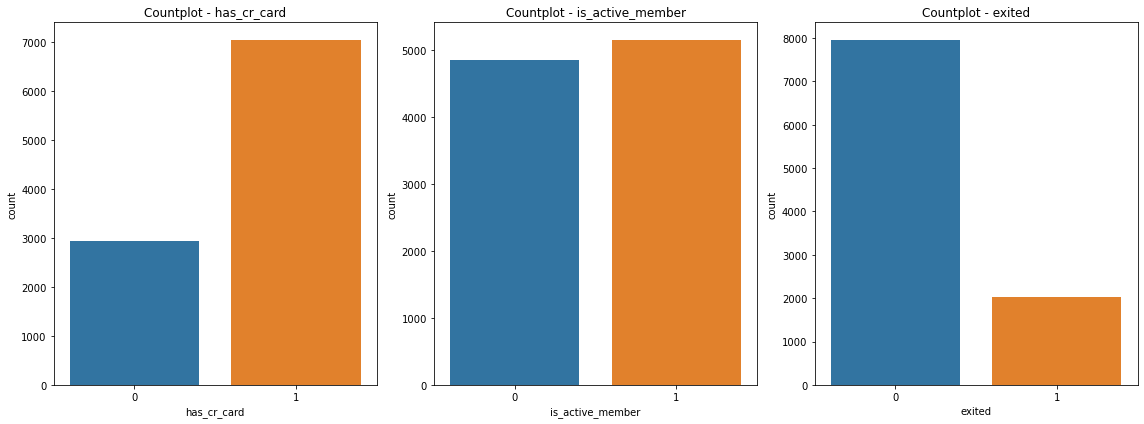

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

for i, col in enumerate(binary_cols):
    ax = axs[i]  
    sns.countplot(data=new_data, x=col, ax=ax)
    ax.set_title(f"Countplot - {col}")

plt.tight_layout()
plt.show()

## Preparando dados

In [85]:
# Separando dataset em objetivo e características
target = new_data['exited']
features = new_data.drop('exited', axis=1)

In [86]:
# Separando dataset em conjunto de validação e treinamento
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [87]:
# Separando dataset em conjunto de validação e de teste
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

In [88]:
#Criando instancia de classe LabelEncoder
label_encoder = LabelEncoder()

In [89]:
# Criando cópia dos dados de treinamento, validação e teste, para evitar modificar os dados originais e perder as
# classificações originais
label_train = features_train.copy()
label_valid = features_valid.copy()
label_test = features_test.copy()

In [90]:
# Laço for que percorre a lista com o nome das colunas e aplica fit_transform na variável que armazena a cópia
# do conjunto de treinamento e transform nas demais
for col in string_cols:
    label_train[col] = label_encoder.fit_transform(features_train[col])
    label_valid[col] = label_encoder.transform(features_valid[col])
    label_test[col] = label_encoder.transform(features_test[col])

## Investigando a qualidade dos diferentes modelos

Para escolher o melhor modelo, bem como seus hiperparâmetros, utilizarei a métrica Balanced Accuracy, que calcula a média da taxa de verdadeiro positivo (sensibilidade) e taxa de verdadeiro negativo (especificidade) e fornece uma visão mais equilibrada do desempenho do classificador.

### Árvore de decisão:

In [91]:
best_model = None
best_result = 0
for depth in range(1, 6):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_tree.fit(label_train, target_train) 
    predicted_valid = model_tree.predict(label_valid)
    result = balanced_accuracy_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model_tree
        best_result = result
        
print("Acurácia balanceada do melhor modelo:", best_result, ", max_depth =", depth)

Acurácia balanceada do melhor modelo: 0.709247311827957 , max_depth = 5


### Floresta aleatória

In [92]:
best_score = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(label_train, target_train)
        predicted_valid = model_forest.predict(label_valid)
        result = balanced_accuracy_score(target_valid, predicted_valid)
        if result > best_score:
            best_score = result
            best_est = est
            best_depth = depth

print("Acurácia balanceada do melhor modelo no conjunto de validação (n_estimators = {}): {}, max_depth = {}".format(best_est, best_score, best_depth))

Acurácia balanceada do melhor modelo no conjunto de validação (n_estimators = 20): 0.7039426523297492, max_depth = 10


### Regressão logística

In [93]:
model_logistic = LogisticRegression(random_state=54321, solver='liblinear') 
model_logistic.fit(label_train, target_train) 
predicted_valid = model_logistic.predict(label_valid)
score = balanced_accuracy_score(target_valid, predicted_valid)

print("Acurácia balanceada do modelo de regressão logística no conjunto de validação:", score)

Acurácia balanceada do modelo de regressão logística no conjunto de validação: 0.5


Os modelos Árvores de decisão e Floresta aleatória obtiveram acurácia balanceada próximas. Dessa forma, irei escolher o modelo Floresta Aleatória com n_estimators = 20 e max_depth = 10, uma vez que esse modelo tem menor subreajuste. 

## Treinando o modelo sem levar em conta o desequilíbrio

Nessa etapa o modelo escolhido (Floresta aleatória) será treinado sem correção do desequilíbrio entre classes.

### Floresta aleatória

In [94]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10)
model_forest.fit(label_train, target_train)
predicted_valid = model_forest.predict(label_valid)

In [95]:
#Matriz de confusão 
confusion = confusion_matrix(target_valid, predicted_valid)
confusion

array([[757,  18],
       [128,  97]])

In [96]:
# Taxa de acerto e erro
hit_rate = accuracy_score(target_valid, predicted_valid)
error_rate = 1 - hit_rate
hit_rate

0.854

In [97]:
# Calculando precisão
precision = precision_score(target_valid, predicted_valid)
precision

0.8434782608695652

In [98]:
#Calculando sensibilidade
recall = recall_score(target_valid, predicted_valid)
recall

0.4311111111111111

In [99]:
# Calculando F1-score do modelo
f1_score(target_valid, predicted_valid)

0.5705882352941177

É possível ver que o modelo, apesar da boa taxa de acerto e precisão, possui sensibidade muito baixa, além disso, o modelo possui um valor de F1-score próximo a 5, que não é mal, mas cabe melhorias. Esse escore combina ambas métricas de precisão e sensibilidade. 

## Melhorando a qualidade do modelo

Nessa etapa irei utilizar duas abordagens para equilibrar as classes: class weighting e resampling

### Abordagem 1 : Class weighting

In [100]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10, class_weight='balanced')
model_forest.fit(label_train, target_train)
predicted_valid = model_forest.predict(label_valid)
probabilities_valid = model_forest.predict_proba(label_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [101]:
# Matriz de confusão
confusion = confusion_matrix(target_valid, predicted_valid)
confusion

array([[693,  82],
       [ 81, 144]])

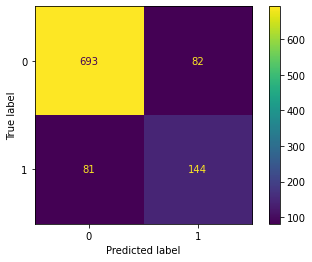

In [102]:
# Plotando representação visual da matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion).plot()
plt.show()

In [103]:
# Calculando taxa de acerto e erro do modelo
hit_rate = accuracy_score(target_valid, predicted_valid)
error_rate = 1 - hit_rate
hit_rate

0.837

In [104]:
# Calculando precisão do modelo
precision = precision_score(target_valid, predicted_valid)
precision

0.6371681415929203

In [105]:
#Caculando sensibilidade do modelo
recall = recall_score(target_valid, predicted_valid)
recall

0.64

In [106]:
# calculando f1_score
f1_score(target_valid, predicted_valid)

0.6385809312638582

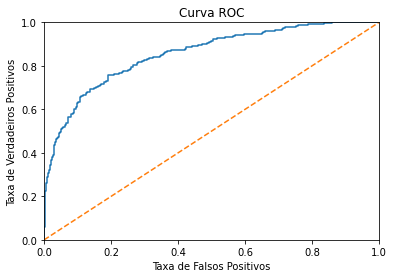

In [107]:
# plotando curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')

plt.show()

In [108]:
# Calculando área sobre a curva ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8552315412186379


### Abordagem 2: Resampling

**Oversampling**

In [109]:
# Criando função que irá aumentar a amostra em n repetições
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [110]:
# Aplicando a função
features_upsampled, target_upsampled = upsample(
    label_train, target_train, 10
)

In [111]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10)
model_forest.fit(features_upsampled, target_upsampled)
predicted_valid = model_forest.predict(label_valid)
probabilities_valid = model_forest.predict_proba(label_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [112]:
# Matriz de confusão
confusion = confusion_matrix(target_valid, predicted_valid)
confusion

array([[495, 280],
       [ 30, 195]])

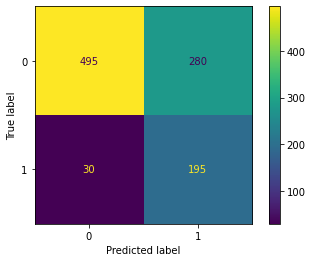

In [113]:
# Plotando representação visual da matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion).plot()
plt.show()

In [114]:
# Calculando tava de acerto e erro do modelo
hit_rate = accuracy_score(target_valid, predicted_valid)
error_rate = 1 - hit_rate
hit_rate

0.69

In [115]:
# Calculando precisão do modelo
precision = precision_score(target_valid, predicted_valid)
precision

0.4105263157894737

In [116]:
# Calculando sensibilidade do modelo
recall = recall_score(target_valid, predicted_valid)
recall

0.8666666666666667

In [117]:
# Calculando F1-score do modelo após oversampling
f1_score(target_valid, predicted_valid)

0.5571428571428572

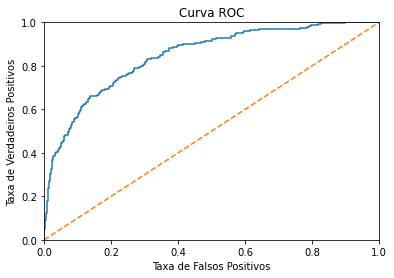

In [118]:
# Plotando curva ROC do modelo com oversampling
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')

plt.show()

In [119]:
# Calculando a área sobre a curva ROC no modelo após oversampling
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8455799283154122


**Undersampling**

In [120]:
# Criando função que irá reduzir a amostra em n frações
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [121]:
#Aplicando função
features_downsampled, target_downsampled = downsample(
    label_train, target_train, 0.1
)

In [122]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10)
model_forest.fit(features_downsampled, target_downsampled)
predicted_valid = model_forest.predict(label_valid)
probabilities_valid = model_forest.predict_proba(label_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [123]:
#Matriz de confusão após undersampling
confusion = confusion_matrix(target_valid, predicted_valid)
confusion

array([[361, 414],
       [ 15, 210]])

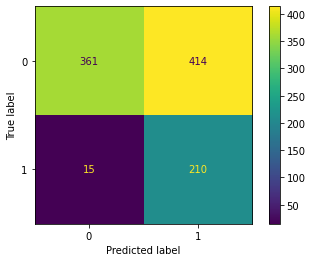

In [124]:
# Plotando representação visual da matriz de confusão do modelo com undersampling
cm_display = ConfusionMatrixDisplay(confusion).plot()
plt.show()

In [125]:
#Calculando taxa de acerto e erro do modelo com undersampling
hit_rate = accuracy_score(target_valid, predicted_valid)
error_rate = 1 - hit_rate
hit_rate

0.571

In [126]:
# Calculando precisão do modelo com undersampling
precision = precision_score(target_valid, predicted_valid)
precision

0.33653846153846156

In [127]:
#Calculando sensibilidade do modelo com undersampling
recall = recall_score(target_valid, predicted_valid)
recall

0.9333333333333333

In [128]:
# Calculando F1-score do modelo após undersampling
f1_score(target_valid, predicted_valid)

0.49469964664310967

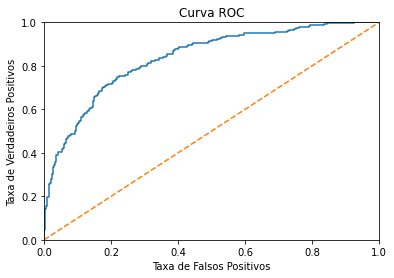

In [129]:
# Plotando curva ROC do modelo com undersampling
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')

plt.show()

In [130]:
# Calculando a área sobre a curva ROC no modelo após undersampling
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8363240143369176


**Conclusão**

Observamos que quando ajustamos o peso das classes temos uma melhoria razoável no score f1. Ao aumentar e reduzir a amostra os valores de score f1 diminuíram, com a amostra reduzida o score f1 ficou abaixo de 0,5. Com relação a curva roc e a área sobre a curva roc (AUC) de ambas abordagens obtiveram valores aproximados, entretanto a abordagem de class weighting teve valor de AUC maior.


## Verificando a qualidade do modelo treinado usando o conjunto de teste

In [131]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10, class_weight='balanced')
model_forest.fit(label_train, target_train)
train_predictions = model_forest.predict(label_train)
test_predictions = model_forest.predict(label_test)

In [133]:
# Matriz de confusão do modelo no conjunto de treinamento
confusion_train = confusion_matrix(target_train, train_predictions)
# Matriz de confusão do modelo no conjunto de teste
confusion_test = confusion_matrix(target_test, test_predictions)
print(f'matriz de confusão conjunto de treinamento:')
print(confusion_train)
print('')
print(f'matriz de confusão conjunto de teste:')
print(confusion_test)

matriz de confusão conjunto de treinamento:
[[5891  499]
 [ 277 1333]]

matriz de confusão conjunto de teste:
[[696 102]
 [ 82 120]]


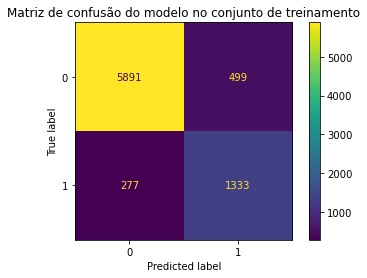

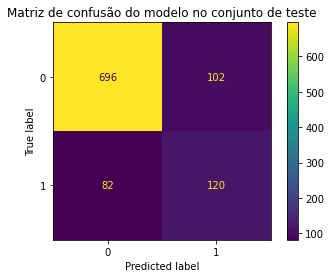

In [134]:
#Plotando matriz de confusão do modelo no conjunto de treinamento
cm_display = ConfusionMatrixDisplay(confusion_train).plot()
plt.title('Matriz de confusão do modelo no conjunto de treinamento')
plt.show()
#Plotando matriz de confusão do modelo no conjunto de teste
cm_display = ConfusionMatrixDisplay(confusion_test).plot()
plt.title('Matriz de confusão do modelo no conjunto de teste')
plt.show()


In [136]:
# Taxa de acerto do modelo no conjunto de treinamento
hit_rate_train = accuracy_score(target_train, train_predictions)
error_rate_train = 1 - hit_rate_train
# Taxa de acerto do modelo no conjunto de teste
hit_rate_test = accuracy_score(target_test, test_predictions)
error_rate_test = 1 - hit_rate_test

# Calculando precisão do modelo no conjunto de treinamento
precision_train = precision_score(target_train, train_predictions)

# Calculando precisão do modelo no conjunto de teste
precision_test = precision_score(target_test, test_predictions)

# Calculando sensibilidade do modelo no conjunto de treinamento
recall_train = recall_score(target_train, train_predictions)

# Calculando sensibilidade do modelo no conjunto de teste
recall_test = recall_score(target_test, test_predictions)

# score f1 do modelo no conjunto de treinamento
f1_train = f1_score(target_train, train_predictions)

# score f1 no conjunto de teste
f1_test = f1_score(target_test, test_predictions)

print('Resultado do modelo no conjunto de treinamento: \n')

print(f'taxa de acerto: {hit_rate_train}')
print(f'Precisão: {precision_train}')
print(f'Sensibilidade: {recall_train}')
print(f'F1-score: {f1_train} \n')

print('Resultado do modelo no conjunto de teste: \n')
print(f'taxa de acerto: {hit_rate_test}')
print(f'Precisão: {precision_test}')
print(f'Sensibilidade: {recall_test}')
print(f'F1-score: {f1_test}')

Resultado do modelo no conjunto de treinamento: 

taxa de acerto: 0.903
Precisão: 0.7276200873362445
Sensibilidade: 0.8279503105590063
F1-score: 0.7745496804183614 

Resultado do modelo no conjunto de teste: 

taxa de acerto: 0.816
Precisão: 0.5405405405405406
Sensibilidade: 0.594059405940594
F1-score: 0.5660377358490566


**Conclusões**

Observamos uma pequena diferença entre o conjunto treinado e o conjunto de teste.

## Teste final

In [137]:
# Aplicando LabelEncoder no dataframe original
label_encoder = LabelEncoder()
for col in string_cols:
    features[col] = label_encoder.fit_transform(features[col])

In [138]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10, class_weight='balanced')
model_forest.fit(features, target)
predicted_valid = model_forest.predict(features)
probabilities = model_forest.predict_proba(features)
probabilities_one = probabilities[:, 1]

In [139]:
# Matriz de confusão do modelo
confusion = confusion_matrix(target, predicted_valid)
confusion

array([[7238,  725],
       [ 396, 1641]])

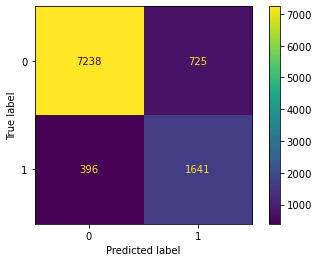

In [140]:
#Plotando matriz de confusão do modelo
cm_display = ConfusionMatrixDisplay(confusion).plot()
plt.show()

In [141]:
# Taxa de acerto do modelo
hit_rate = accuracy_score(target, predicted_valid)
error_rate = 1 - hit_rate
hit_rate

0.8879

In [142]:
# Calculando precisão do modelo
precision = precision_score(target, predicted_valid)
precision

0.6935756551141167

In [143]:
# Calculando sensibilidade do modelo
recall = recall_score(target, predicted_valid)
recall

0.8055964653902798

In [144]:
# score f1 do modelo
f1_score(target, predicted_valid)

0.745400863047922

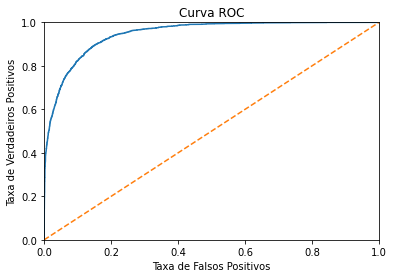

In [145]:
#Plotando curva ROC do modelo
fpr, tpr, thresholds = roc_curve(target, probabilities_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')

plt.show()

In [146]:
# Calculando área sobre curva ROC do modelo
auc_roc = roc_auc_score(target, probabilities_one)
auc_roc

0.9466070093080842

**conclusões**

Aplicando o modelo com o dataset completo obtivemos uma boa taxa de acertos, score f1 bem acima de 0,5 e a área sobre a curva ROC próximo a 1. Isso quer dizer que o modelo é bom em prever se um cliente deixará o banco em breve, com boa precisão, sensibilidade e especificidade.